In [55]:
import pandas as pd
import requests
import io
import re
import matplotlib.pyplot as plt

In [2]:
def fetch_go_annotations(uniprot_ids):
    """ Fetch GO annotations from UniProt for a list of UniProt IDs. """
    url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        "format": "tsv",
        "query": " OR ".join(f"id:{up_id}" for up_id in uniprot_ids),
        "fields": "id,go_p,go_c,go_f"
        ""
    }
    print(f"Fetching GO annotations for {len(uniprot_ids)} UniProt IDs..."
            f" (query: {params['query']})")
    response = requests.get(url, params=params)
    response.raise_for_status()
    print(response.text)
    print(response.url)
    return pd.read_csv(io.StringIO(response.text), sep='\t')

In [3]:
uniprot_ids = ["O75251"]

go_annotations = fetch_go_annotations(uniprot_ids)

Fetching GO annotations for 1 UniProt IDs... (query: id:O75251)
Entry Name	Gene Ontology (biological process)	Gene Ontology (cellular component)	Gene Ontology (molecular function)

https://rest.uniprot.org/uniprotkb/search?format=tsv&query=id%3AO75251&fields=id%2Cgo_p%2Cgo_c%2Cgo_f


In [4]:
display(go_annotations)

,Entry Name,Gene Ontology (biological process),Gene Ontology (cellular component),Gene Ontology (molecular function)


In [5]:
def fetch_ec_numbers(uniprot_ids):
    ec_numbers = []
    url_base = "https://www.uniprot.org/uniprot/"

    for uniprot_id in uniprot_ids:
        url = f"{url_base}{uniprot_id}.txt"
        response = requests.get(url)
        
        if response.status_code == 200:
            text_data = response.text
            for line in text_data.splitlines():
                if "EC=" in line:
                    parts = line.split(";")
                    for part in parts:
                        if "EC=" in part:
                            ec_data = part.split("=")[1].strip()
                            # Regular expression to extract only the EC number
                            match = re.match(r"(\d+\.\d+\.\d+\.\d+)", ec_data)
                            if match:
                                ec_number = match.group(1)
                                ec_numbers.append(ec_number)
                            break
        else:
            print(f"Failed to retrieve data for UniProt ID {uniprot_id}")
    
    return ec_numbers

In [17]:
data = pd.read_csv("../data/opentargets/known_drugs_targets.csv")
uniprot_ids = data["target"]
uniprot_ids = uniprot_ids.str.replace("UniProtKB:", "")
#uniprot_ids = uniprot_ids.head(100)
uniprot_ids = uniprot_ids.tolist()
ec_numbers = fetch_ec_numbers(uniprot_ids)
print(ec_numbers)

ec_numbers_df = pd.DataFrame({"target_ec_number": ec_numbers})
ec_numbers_df.to_csv("target_ec_numbers.csv", index=False)

simplified_versions = ['.'.join(num.split('.')[:2]) for num in ec_numbers]
print(simplified_versions)
simplified_versions_df = pd.DataFrame({'target_ec_number': simplified_versions})
simplified_versions_df['target_ec_number'].nunique()
simplified_versions_df.to_csv("simplified_target_ec_numbers.csv", index=False)

['7.1.1.2', '7.1.1.2', '2.7.1.137', '2.7.1.153', '2.7.11.1', '2.7.1.153', '2.7.1.137', '2.7.11.1', '2.7.10.1', '2.7.10.1', '2.7.1.137', '2.7.1.153', '2.7.1.153', '2.7.1.137', '5.6.2.2', '5.6.2.2', '5.6.2.2', '5.6.2.2', '2.7.10.2', '2.7.10.2', '2.7.10.1', '2.7.10.1', '2.7.10.1', '2.7.10.1', '2.7.10.1', '2.7.10.1', '2.1.1.45', '2.1.1.45', '2.7.10.1', '2.7.10.1', '2.7.10.1', '2.7.10.1', '3.4.25.1', '3.4.25.1', '2.7.10.1', '2.7.10.1', '1.14.99.1', '1.14.99.1', '3.5.1.98', '3.5.1.98', '1.1.1.34', '1.1.1.34', '2.7.11.22', '2.7.11.22', '2.7.11.22', '2.7.10.1', '2.7.10.1', '3.5.1.98', '3.5.1.98', '5.6.2.2', '5.6.2.2', '1.17.4.1', '1.17.4.1', '2.7.7.102', '2.7.7.102', '2.7.7.7', '2.7.7.7', '2.7.7.7', '2.7.7.7', '2.7.7.102', '2.7.7.102', '2.7.10.1', '2.7.10.1', '2.7.11.1', '2.7.11.1', '2.7.11.1', '2.1.1.37', '2.1.1.37', '2.7.7.7', '2.7.7.7', '5.2.1.8', '5.2.1.8', '3.4.25.1', '3.4.25.1', '2.7.10.1', '2.7.10.1', '2.7.10.1', '2.7.10.1', '2.7.10.1', '2.7.10.1', '2.7.11.13', '2.7.11.13', '2.7.11.13',

In [51]:
targets_ec_numbers = pd.read_csv("target_ec_numbers.csv")

In [59]:
targets_ec_numbers['simplified_ec_number_1'] = targets_ec_numbers['target_ec_number'].apply(lambda x: '.'.join(x.split('.')[:2]))

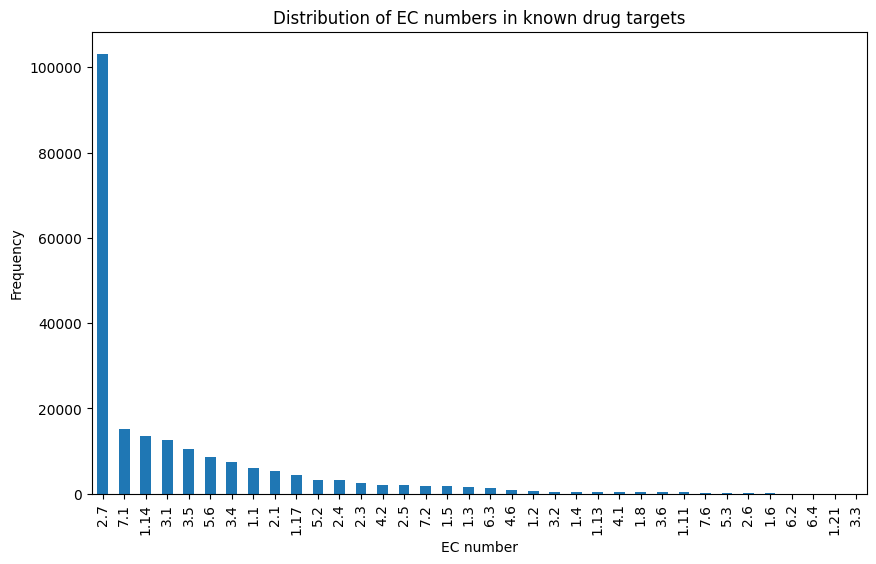

In [60]:
plt.figure(figsize=(10, 6))
targets_ec_numbers['simplified_ec_number_1'].value_counts().plot(kind='bar')
plt.xlabel('EC number')
plt.ylabel('Frequency')
plt.title('Distribution of EC numbers in known drug targets')
plt.show()

In [61]:
display(pd.concat([targets_ec_numbers["simplified_ec_number_1"].value_counts(), targets_ec_numbers["simplified_ec_number_1"].value_counts(normalize=True)], axis=1, keys=["Count", "%"]))
print('Unique counts: ', targets_ec_numbers["simplified_ec_number_1"].nunique())

,Count,%
simplified_ec_number_1,,
2.7,103203,0.489425
7.1,15092,0.071572
1.14,13475,0.063903
3.1,12564,0.059583
3.5,10494,0.049766
5.6,8656,0.041050
3.4,7546,0.035786
1.1,5921,0.028079
2.1,5214,0.024727


Unique counts:  36


In [62]:
def simplify_ec_number_2(ec):
    parts = ec.split('.')
    if ec.startswith('2.7'):
        return '.'.join(parts[:3])
    else:
        return '.'.join(parts[:2])

In [63]:
targets_ec_numbers['simplified_ec_number_2'] = targets_ec_numbers['target_ec_number'].apply(simplify_ec_number_2)

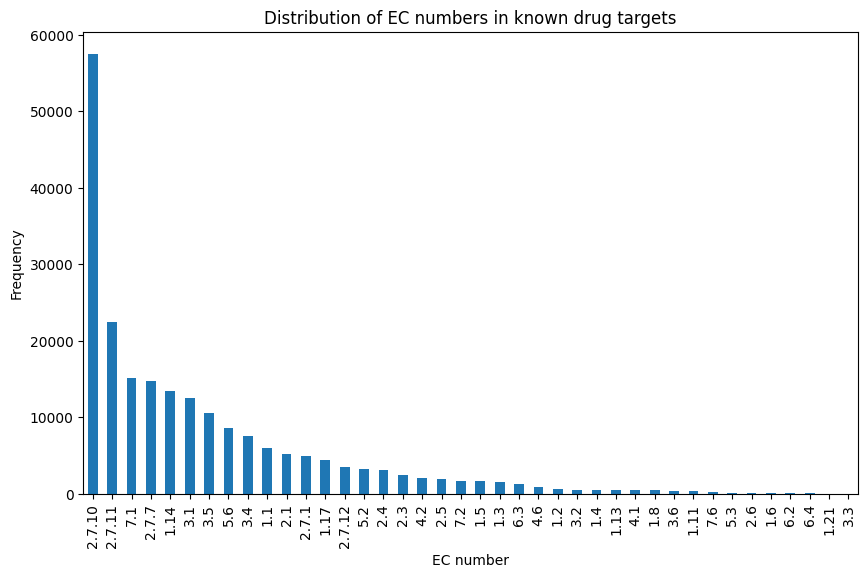

In [64]:
plt.figure(figsize=(10, 6))
targets_ec_numbers['simplified_ec_number_2'].value_counts().plot(kind='bar')
plt.xlabel('EC number')
plt.ylabel('Frequency')
plt.title('Distribution of EC numbers in known drug targets')
plt.show()

In [65]:
display(pd.concat([targets_ec_numbers["simplified_ec_number_2"].value_counts(), targets_ec_numbers["simplified_ec_number_2"].value_counts(normalize=True)], axis=1, keys=["Count", "%"]))
print('Unique counts: ', targets_ec_numbers["simplified_ec_number_2"].nunique())

,Count,%
simplified_ec_number_2,,
2.7.10,57525,0.272804
2.7.11,22471,0.106565
7.1,15092,0.071572
2.7.7,14752,0.069959
1.14,13475,0.063903
3.1,12564,0.059583
3.5,10494,0.049766
5.6,8656,0.041050
3.4,7546,0.035786


Unique counts:  40


In [52]:
def simplify_ec_number(ec):
    parts = ec.split('.')
    if ec.startswith('2.7.10'):
        return '.'.join(parts[:5])
    elif ec.startswith('2.7'):
        return '.'.join(parts[:3])
    else:
        return '.'.join(parts[:2])

In [53]:
targets_ec_numbers['simplified_ec_number'] = targets_ec_numbers['target_ec_number'].apply(simplify_ec_number)

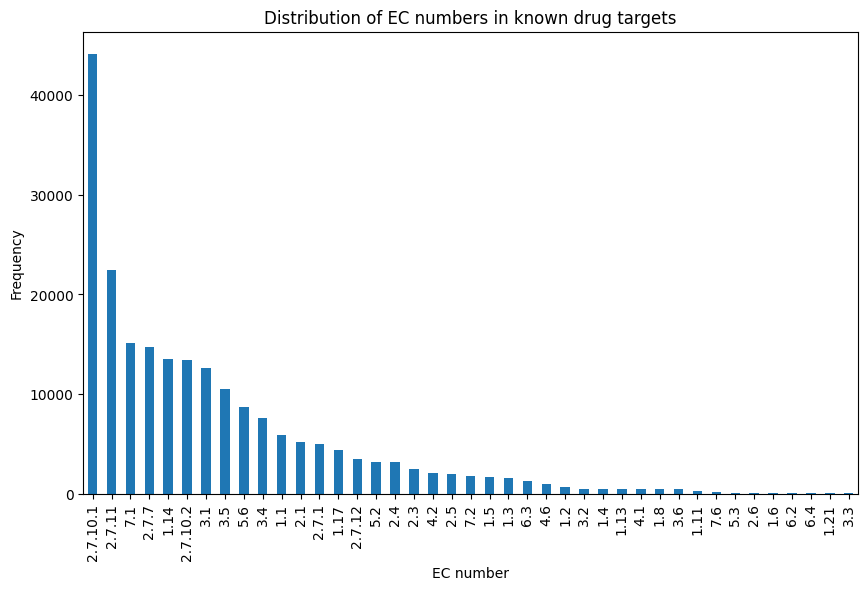

In [54]:
plt.figure(figsize=(10, 6))
targets_ec_numbers['simplified_ec_number'].value_counts().plot(kind='bar')
plt.xlabel('EC number')
plt.ylabel('Frequency')
plt.title('Distribution of EC numbers in known drug targets')
plt.show()

In [58]:
display(pd.concat([targets_ec_numbers["simplified_ec_number"].value_counts(), targets_ec_numbers["simplified_ec_number"].value_counts(normalize=True)], axis=1, keys=["Count", "%"]))
print('Unique counts: ', targets_ec_numbers["simplified_ec_number"].nunique())

,Count,%
simplified_ec_number,,
2.7.10.1,44154,0.209394
2.7.11,22471,0.106565
7.1,15092,0.071572
2.7.7,14752,0.069959
1.14,13475,0.063903
2.7.10.2,13371,0.063410
3.1,12564,0.059583
3.5,10494,0.049766
5.6,8656,0.041050


Unique counts:  41
